In [179]:
import pandas as pd
import numpy as np
from transformers import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
import pypyodbc 

In [43]:
cnxn = pypyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=DESKTOP-29S9HKA;"
                        "Database=AppStore;"
                        "Trusted_Connection=yes;")
df = pd.read_sql_query('''select distinct top 200 UserSk, fact_review.score, comment, GenreSk, review.reviewSk from review, fact_review, fact_app where fact_review.AppSk=fact_app.AppSk and fact_review.reviewSk=review.reviewSk and not UserSk=29
union
select distinct top 200 UserSk, fact_review.score, comment, GenreSk, review.reviewSk from review, fact_review, fact_app where fact_review.AppSk=fact_app.AppSk and fact_review.reviewSk=review.reviewSk and not UserSk=29 and GenreSK=1
union
select distinct top 200 UserSk, fact_review.score, comment, GenreSk, review.reviewSk from review, fact_review, fact_app where fact_review.AppSk=fact_app.AppSk and fact_review.reviewSk=review.reviewSk and not UserSk=29 and GenreSK=2
union
select distinct top 200 UserSk, fact_review.score, comment, GenreSk, review.reviewSk from review, fact_review, fact_app where fact_review.AppSk=fact_app.AppSk and fact_review.reviewSk=review.reviewSk and not UserSk=29 and GenreSK=3
union
select distinct top 200 UserSk, fact_review.score, comment, GenreSk, review.reviewSk from review, fact_review, fact_app where fact_review.AppSk=fact_app.AppSk and fact_review.reviewSk=review.reviewSk and not UserSk=29 and GenreSK=4
''', cnxn)
df

C:\Users\ale11\AppData\Local\Temp\ipykernel_61112\2586635567.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('''select distinct top 200 UserSk, fact_review.score, comment, GenreSk, review.reviewSk from review, fact_review, fact_app where fact_review.AppSk=fact_app.AppSk and fact_review.reviewSk=review.reviewSk and not UserSk=29


,usersk,score,comment,genresk,reviewsk
0,11,4.0,Good app.......,14,21184
1,26,5.0,Very accurate the vast majority of the time.,2,37273
2,55,1.0,Ù„Ø¹Ø¨Ù‡ Ø³ÙŠØ¦Ù‡ Ø§Ù„Ø¨Ù†Ù‚ Ø¯Ø§Ø¦Ù…Ø§ Ù…Ø±Øª...,14,33484
3,80,5.0,This is very good editing app please download ...,1,51433
4,81,4.0,good,1,15495
...,...,...,...,...,...
995,22902,5.0,Catogorized.,4,115198
996,22923,5.0,good,4,134792
997,22931,5.0,بببلبب,3,135197
998,22932,1.0,Doesn't free👎.. Doesn't work,3,192969


In [23]:
emotion_classifier = pipeline(
    "text-classification",
    model="SamLowe/roberta-base-go_emotions",
    return_all_scores=True
)

C:\Users\ale11\anaconda3\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\ale11\anaconda3\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [45]:
reviews=[]
sentiment=[]
for i, text in df.iterrows():

    if text['comment']== None:
        text['comment']="" 
    results = emotion_classifier(text['comment'])[0]
    results_sorted = sorted(results, key=lambda x: x['score'], reverse=True)

    sentiment.append(results_sorted[0]['label'])
    
    emotion_vector={entry['label']: entry['score'] for entry in results_sorted}
    emotion_vector['reviewsk']=text['reviewsk']
    
    reviews.append(emotion_vector)
    
reviews_analized = pd.DataFrame(reviews)

In [47]:
reviews_analized = reviews_analized.set_index('reviewsk')
reviews_analized

,admiration,approval,neutral,gratitude,excitement,optimism,realization,curiosity,disapproval,annoyance,...,caring,sadness,disgust,desire,fear,relief,embarrassment,grief,remorse,nervousness
reviewsk,,,,,,,,,,,,,,,,,,,,,
21184,0.952407,0.035722,0.018621,0.008089,0.005357,0.005288,0.004592,0.004367,0.004235,0.003373,...,0.001536,0.001472,0.000938,0.000908,0.000521,0.000505,0.000333,0.000319,0.000288,0.000176
37273,0.030679,0.868227,0.059097,0.007364,0.002846,0.024590,0.033193,0.004353,0.005637,0.005220,...,0.003570,0.001319,0.001651,0.001940,0.001526,0.002888,0.000577,0.000359,0.000667,0.000595
33484,0.002395,0.016938,0.944641,0.000312,0.002955,0.001597,0.005774,0.004531,0.003291,0.005071,...,0.001200,0.003185,0.002785,0.000927,0.002556,0.000289,0.000834,0.000595,0.000344,0.000523
51433,0.895078,0.183130,0.032946,0.027178,0.004543,0.019904,0.005812,0.003366,0.004887,0.003214,...,0.006739,0.000964,0.000635,0.005343,0.000363,0.000969,0.000182,0.000255,0.000416,0.000172
15495,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.002440,0.001117,0.000537,0.000856,0.000362,0.001348,0.000221,0.000307,0.000267,0.000153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115198,0.005964,0.015944,0.964291,0.001109,0.003557,0.001710,0.006545,0.001215,0.003085,0.005875,...,0.000905,0.002243,0.003019,0.001146,0.002169,0.000477,0.000943,0.000512,0.000397,0.000439
134792,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.002440,0.001117,0.000537,0.000856,0.000362,0.001348,0.000221,0.000307,0.000267,0.000153
135197,0.002448,0.010344,0.963239,0.000718,0.001568,0.001811,0.005072,0.001494,0.003932,0.011296,...,0.001592,0.003400,0.005181,0.001540,0.002946,0.000352,0.001108,0.000594,0.000471,0.000556


In [49]:
reviews_analized['genre']=df['genresk'].values
reviews_analized['score']=df['score'].values
reviews_analized

,admiration,approval,neutral,gratitude,excitement,optimism,realization,curiosity,disapproval,annoyance,...,disgust,desire,fear,relief,embarrassment,grief,remorse,nervousness,genre,score
reviewsk,,,,,,,,,,,,,,,,,,,,,
21184,0.952407,0.035722,0.018621,0.008089,0.005357,0.005288,0.004592,0.004367,0.004235,0.003373,...,0.000938,0.000908,0.000521,0.000505,0.000333,0.000319,0.000288,0.000176,14,4.0
37273,0.030679,0.868227,0.059097,0.007364,0.002846,0.024590,0.033193,0.004353,0.005637,0.005220,...,0.001651,0.001940,0.001526,0.002888,0.000577,0.000359,0.000667,0.000595,2,5.0
33484,0.002395,0.016938,0.944641,0.000312,0.002955,0.001597,0.005774,0.004531,0.003291,0.005071,...,0.002785,0.000927,0.002556,0.000289,0.000834,0.000595,0.000344,0.000523,14,1.0
51433,0.895078,0.183130,0.032946,0.027178,0.004543,0.019904,0.005812,0.003366,0.004887,0.003214,...,0.000635,0.005343,0.000363,0.000969,0.000182,0.000255,0.000416,0.000172,1,5.0
15495,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.000537,0.000856,0.000362,0.001348,0.000221,0.000307,0.000267,0.000153,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115198,0.005964,0.015944,0.964291,0.001109,0.003557,0.001710,0.006545,0.001215,0.003085,0.005875,...,0.003019,0.001146,0.002169,0.000477,0.000943,0.000512,0.000397,0.000439,4,5.0
134792,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.000537,0.000856,0.000362,0.001348,0.000221,0.000307,0.000267,0.000153,4,5.0
135197,0.002448,0.010344,0.963239,0.000718,0.001568,0.001811,0.005072,0.001494,0.003932,0.011296,...,0.005181,0.001540,0.002946,0.000352,0.001108,0.000594,0.000471,0.000556,3,5.0


In [51]:
reviews_dumm= pd.get_dummies(reviews_analized,columns=['genre'])
reviews_dumm

,admiration,approval,neutral,gratitude,excitement,optimism,realization,curiosity,disapproval,annoyance,...,embarrassment,grief,remorse,nervousness,score,genre_1,genre_2,genre_3,genre_4,genre_14
reviewsk,,,,,,,,,,,,,,,,,,,,,
21184,0.952407,0.035722,0.018621,0.008089,0.005357,0.005288,0.004592,0.004367,0.004235,0.003373,...,0.000333,0.000319,0.000288,0.000176,4.0,False,False,False,False,True
37273,0.030679,0.868227,0.059097,0.007364,0.002846,0.024590,0.033193,0.004353,0.005637,0.005220,...,0.000577,0.000359,0.000667,0.000595,5.0,False,True,False,False,False
33484,0.002395,0.016938,0.944641,0.000312,0.002955,0.001597,0.005774,0.004531,0.003291,0.005071,...,0.000834,0.000595,0.000344,0.000523,1.0,False,False,False,False,True
51433,0.895078,0.183130,0.032946,0.027178,0.004543,0.019904,0.005812,0.003366,0.004887,0.003214,...,0.000182,0.000255,0.000416,0.000172,5.0,True,False,False,False,False
15495,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.000221,0.000307,0.000267,0.000153,4.0,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115198,0.005964,0.015944,0.964291,0.001109,0.003557,0.001710,0.006545,0.001215,0.003085,0.005875,...,0.000943,0.000512,0.000397,0.000439,5.0,False,False,False,True,False
134792,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.000221,0.000307,0.000267,0.000153,5.0,False,False,False,True,False
135197,0.002448,0.010344,0.963239,0.000718,0.001568,0.001811,0.005072,0.001494,0.003932,0.011296,...,0.001108,0.000594,0.000471,0.000556,5.0,False,False,True,False,False


In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(reviews_dumm)
X_scaled

array([[ 1.42241972, -0.37302821, -0.7752773 , ..., -0.5       ,
        -0.5       ,  2.        ],
       [-0.7957964 ,  6.60838506, -0.6638161 , ..., -0.5       ,
        -0.5       , -0.5       ],
       [-0.86386642, -0.53055482,  1.77475572, ..., -0.5       ,
        -0.5       ,  2.        ],
       ...,
       [-0.86373853, -0.58585537,  1.82597049, ...,  2.        ,
        -0.5       , -0.5       ],
       [-0.86537764, -0.30385374, -0.39642059, ...,  2.        ,
        -0.5       , -0.5       ],
       [-0.80080441,  0.67697366, -0.63975943, ..., -0.5       ,
         2.        , -0.5       ]])

In [61]:
best_k = 0
best_score = -1

for k in range(2, 10):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}, silhouette_score={score:.4f}")
    
    if score > best_score:
        best_k = k
        best_score = score

print(f"Best k based on silhouette score: {best_k}")

k=2, silhouette_score=0.3097
k=3, silhouette_score=0.1103
k=4, silhouette_score=0.1118
k=5, silhouette_score=0.1146
k=6, silhouette_score=0.1426
k=7, silhouette_score=0.1496
k=8, silhouette_score=0.1291
k=9, silhouette_score=0.1367
Best k based on silhouette score: 2


C:\Users\ale11\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\ale11\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\ale11\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\ale11\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

In [63]:
k = 9
model = KMeans(n_clusters=k, random_state=42)
clusters = model.fit_predict(X_scaled)

clusters

C:\Users\ale11\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


array([6, 6, 1, 2, 2, 6, 0, 6, 6, 6, 6, 2, 1, 5, 6, 2, 2, 5, 1, 2, 0, 0,
       6, 2, 6, 2, 6, 1, 6, 6, 6, 1, 2, 2, 6, 6, 1, 1, 0, 6, 1, 2, 1, 1,
       6, 0, 6, 6, 2, 2, 6, 1, 2, 2, 6, 5, 2, 1, 1, 1, 1, 6, 1, 6, 2, 6,
       1, 6, 6, 0, 6, 0, 1, 6, 6, 1, 2, 1, 2, 1, 0, 2, 2, 2, 1, 6, 2, 2,
       8, 8, 2, 1, 2, 6, 1, 1, 0, 6, 1, 1, 2, 6, 2, 6, 1, 0, 1, 1, 1, 2,
       0, 1, 6, 1, 1, 5, 6, 2, 1, 2, 1, 6, 0, 6, 6, 1, 0, 5, 8, 6, 1, 1,
       2, 2, 7, 2, 6, 6, 6, 1, 0, 1, 2, 6, 0, 8, 1, 1, 2, 5, 2, 1, 2, 2,
       8, 1, 2, 6, 1, 6, 6, 6, 1, 2, 7, 6, 6, 6, 0, 6, 6, 0, 6, 2, 2, 5,
       1, 0, 0, 1, 6, 0, 6, 0, 6, 1, 6, 1, 1, 1, 6, 2, 6, 1, 1, 6, 1, 6,
       0, 6, 2, 8, 6, 0, 6, 1, 1, 1, 1, 6, 2, 2, 2, 6, 1, 6, 1, 2, 2, 6,
       1, 2, 0, 1, 1, 7, 1, 6, 8, 2, 6, 5, 1, 6, 6, 2, 1, 0, 6, 1, 2, 0,
       0, 6, 2, 0, 1, 6, 1, 2, 6, 2, 2, 4, 2, 0, 2, 6, 2, 6, 6, 0, 1, 2,
       0, 0, 2, 0, 0, 2, 6, 2, 2, 2, 0, 6, 2, 2, 6, 0, 2, 6, 2, 1, 1, 1,
       0, 6, 5, 2, 2, 6, 2, 1, 2, 1, 6, 2, 0, 0, 2,

In [73]:
reviews_dumm['cluster']=clusters

In [75]:
reviews_dumm

,admiration,approval,neutral,gratitude,excitement,optimism,realization,curiosity,disapproval,annoyance,...,grief,remorse,nervousness,score,genre_1,genre_2,genre_3,genre_4,genre_14,cluster
reviewsk,,,,,,,,,,,,,,,,,,,,,
21184,0.952407,0.035722,0.018621,0.008089,0.005357,0.005288,0.004592,0.004367,0.004235,0.003373,...,0.000319,0.000288,0.000176,4.0,False,False,False,False,True,6
37273,0.030679,0.868227,0.059097,0.007364,0.002846,0.024590,0.033193,0.004353,0.005637,0.005220,...,0.000359,0.000667,0.000595,5.0,False,True,False,False,False,6
33484,0.002395,0.016938,0.944641,0.000312,0.002955,0.001597,0.005774,0.004531,0.003291,0.005071,...,0.000595,0.000344,0.000523,1.0,False,False,False,False,True,1
51433,0.895078,0.183130,0.032946,0.027178,0.004543,0.019904,0.005812,0.003366,0.004887,0.003214,...,0.000255,0.000416,0.000172,5.0,True,False,False,False,False,2
15495,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.000307,0.000267,0.000153,4.0,True,False,False,False,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115198,0.005964,0.015944,0.964291,0.001109,0.003557,0.001710,0.006545,0.001215,0.003085,0.005875,...,0.000512,0.000397,0.000439,5.0,False,False,False,True,False,1
134792,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.000307,0.000267,0.000153,5.0,False,False,False,True,False,6
135197,0.002448,0.010344,0.963239,0.000718,0.001568,0.001811,0.005072,0.001494,0.003932,0.011296,...,0.000594,0.000471,0.000556,5.0,False,False,True,False,False,1


In [81]:
cluster_profiles = reviews_dumm.groupby('cluster').mean()

In [83]:
cluster_profiles.style

,admiration,approval,neutral,gratitude,excitement,optimism,realization,curiosity,disapproval,annoyance,joy,surprise,disappointment,confusion,love,pride,amusement,anger,caring,sadness,disgust,desire,fear,relief,embarrassment,grief,remorse,nervousness,score,genre_1,genre_2,genre_3,genre_4,genre_14
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.031130,0.030457,0.232222,0.006780,0.002239,0.006534,0.035961,0.008285,0.208580,0.193759,0.003565,0.015906,0.283899,0.035639,0.034203,0.001161,0.002129,0.028630,0.006625,0.051235,0.015266,0.007224,0.002799,0.002373,0.006402,0.001619,0.003785,0.004033,1.714286,0.063492,0.333333,0.412698,0.103175,0.087302
1,0.010365,0.040544,0.814199,0.000989,0.002916,0.006543,0.011725,0.022410,0.037507,0.020940,0.002026,0.002242,0.009842,0.016237,0.006397,0.000485,0.002090,0.004015,0.002945,0.003359,0.003511,0.040381,0.001462,0.000592,0.001072,0.000463,0.000554,0.000581,3.321678,0.125874,0.216783,0.206294,0.209790,0.241259
2,0.677575,0.125214,0.079359,0.065181,0.007860,0.013131,0.008855,0.002682,0.006287,0.003868,0.009897,0.006509,0.002698,0.002333,0.077957,0.002461,0.001580,0.001306,0.007053,0.001538,0.000910,0.004165,0.000591,0.001882,0.000340,0.000353,0.000524,0.000313,4.728477,1.000000,0.000000,0.000000,0.000000,0.000000
3,0.006855,0.024637,0.012792,0.006620,0.001539,0.022019,0.021690,0.013984,0.015410,0.007259,0.003864,0.001848,0.023245,0.009119,0.011961,0.000580,0.052851,0.004703,0.014952,0.294787,0.003801,0.007164,0.001699,0.001673,0.020400,0.006329,0.791217,0.002862,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
4,0.122244,0.021275,0.020417,0.004008,0.008516,0.009177,0.015054,0.004256,0.020127,0.018708,0.005977,0.011902,0.018562,0.006092,0.006296,0.002133,0.005259,0.010932,0.007445,0.028038,0.057290,0.004339,0.810459,0.002379,0.004620,0.004689,0.001521,0.027967,1.000000,0.000000,0.500000,0.500000,0.000000,0.000000
5,0.259041,0.153917,0.067098,0.015317,0.041749,0.011159,0.015376,0.003687,0.004878,0.006115,0.475027,0.002471,0.002925,0.004278,0.030317,0.009975,0.195848,0.002015,0.021839,0.005578,0.000971,0.002980,0.000830,0.025152,0.001092,0.001173,0.004597,0.001356,4.814815,0.185185,0.222222,0.037037,0.296296,0.259259
6,0.624510,0.105810,0.057877,0.047141,0.009998,0.012791,0.008504,0.003051,0.006428,0.004277,0.013492,0.007263,0.004171,0.002732,0.212154,0.002507,0.002812,0.001686,0.010325,0.001966,0.001106,0.009336,0.000636,0.001414,0.000418,0.000403,0.000678,0.000339,4.635204,0.000000,0.204082,0.211735,0.301020,0.283163
7,0.001957,0.007680,0.092005,0.001517,0.001261,0.002553,0.006199,0.007724,0.095799,0.446333,0.001554,0.002329,0.027409,0.012616,0.001179,0.000479,0.001585,0.570254,0.002538,0.006342,0.018717,0.001825,0.001579,0.000338,0.003644,0.000660,0.000841,0.000796,1.250000,0.000000,1.000000,0.000000,0.000000,0.000000
8,0.008390,0.012089,0.102773,0.003049,0.002423,0.002703,0.007664,0.006592,0.068827,0.172056,0.001753,0.003116,0.080861,0.008223,0.006183,0.000717,0.006156,0.068097,0.002533,0.028351,0.473437,0.004345,0.042772,0.000837,0.072906,0.001470,0.003902,0.003537,1.363636,0.000000,0.454545,0.272727,0.090909,0.181818


In [105]:
reviews_analized.drop(['score', 'genre'], axis=1).columns.values

array(['admiration', 'approval', 'neutral', 'gratitude', 'excitement',
       'optimism', 'realization', 'curiosity', 'disapproval', 'annoyance',
       'joy', 'surprise', 'disappointment', 'confusion', 'love', 'pride',
       'amusement', 'anger', 'caring', 'sadness', 'disgust', 'desire',
       'fear', 'relief', 'embarrassment', 'grief', 'remorse',
       'nervousness', 'cluster'], dtype=object)

In [107]:
sentiment_profiles=cluster_profiles[reviews_analized.drop(['score', 'genre','cluster'], axis=1).columns]
sentiment_profiles

,admiration,approval,neutral,gratitude,excitement,optimism,realization,curiosity,disapproval,annoyance,...,caring,sadness,disgust,desire,fear,relief,embarrassment,grief,remorse,nervousness
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.031130,0.030457,0.232222,0.006780,0.002239,0.006534,0.035961,0.008285,0.208580,0.193759,...,0.006625,0.051235,0.015266,0.007224,0.002799,0.002373,0.006402,0.001619,0.003785,0.004033
1,0.010365,0.040544,0.814199,0.000989,0.002916,0.006543,0.011725,0.022410,0.037507,0.020940,...,0.002945,0.003359,0.003511,0.040381,0.001462,0.000592,0.001072,0.000463,0.000554,0.000581
2,0.677575,0.125214,0.079359,0.065181,0.007860,0.013131,0.008855,0.002682,0.006287,0.003868,...,0.007053,0.001538,0.000910,0.004165,0.000591,0.001882,0.000340,0.000353,0.000524,0.000313
3,0.006855,0.024637,0.012792,0.006620,0.001539,0.022019,0.021690,0.013984,0.015410,0.007259,...,0.014952,0.294787,0.003801,0.007164,0.001699,0.001673,0.020400,0.006329,0.791217,0.002862
4,0.122244,0.021275,0.020417,0.004008,0.008516,0.009177,0.015054,0.004256,0.020127,0.018708,...,0.007445,0.028038,0.057290,0.004339,0.810459,0.002379,0.004620,0.004689,0.001521,0.027967
5,0.259041,0.153917,0.067098,0.015317,0.041749,0.011159,0.015376,0.003687,0.004878,0.006115,...,0.021839,0.005578,0.000971,0.002980,0.000830,0.025152,0.001092,0.001173,0.004597,0.001356
6,0.624510,0.105810,0.057877,0.047141,0.009998,0.012791,0.008504,0.003051,0.006428,0.004277,...,0.010325,0.001966,0.001106,0.009336,0.000636,0.001414,0.000418,0.000403,0.000678,0.000339
7,0.001957,0.007680,0.092005,0.001517,0.001261,0.002553,0.006199,0.007724,0.095799,0.446333,...,0.002538,0.006342,0.018717,0.001825,0.001579,0.000338,0.003644,0.000660,0.000841,0.000796
8,0.008390,0.012089,0.102773,0.003049,0.002423,0.002703,0.007664,0.006592,0.068827,0.172056,...,0.002533,0.028351,0.473437,0.004345,0.042772,0.000837,0.072906,0.001470,0.003902,0.003537


In [115]:
genre_profiles=cluster_profiles.filter(like='genre', axis=1)
genre_profiles

,genre_1,genre_2,genre_3,genre_4,genre_14
cluster,,,,,
0,0.063492,0.333333,0.412698,0.103175,0.087302
1,0.125874,0.216783,0.206294,0.209790,0.241259
2,1.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,1.000000,0.000000,0.000000
4,0.000000,0.500000,0.500000,0.000000,0.000000
5,0.185185,0.222222,0.037037,0.296296,0.259259
6,0.000000,0.204082,0.211735,0.301020,0.283163
7,0.000000,1.000000,0.000000,0.000000,0.000000
8,0.000000,0.454545,0.272727,0.090909,0.181818


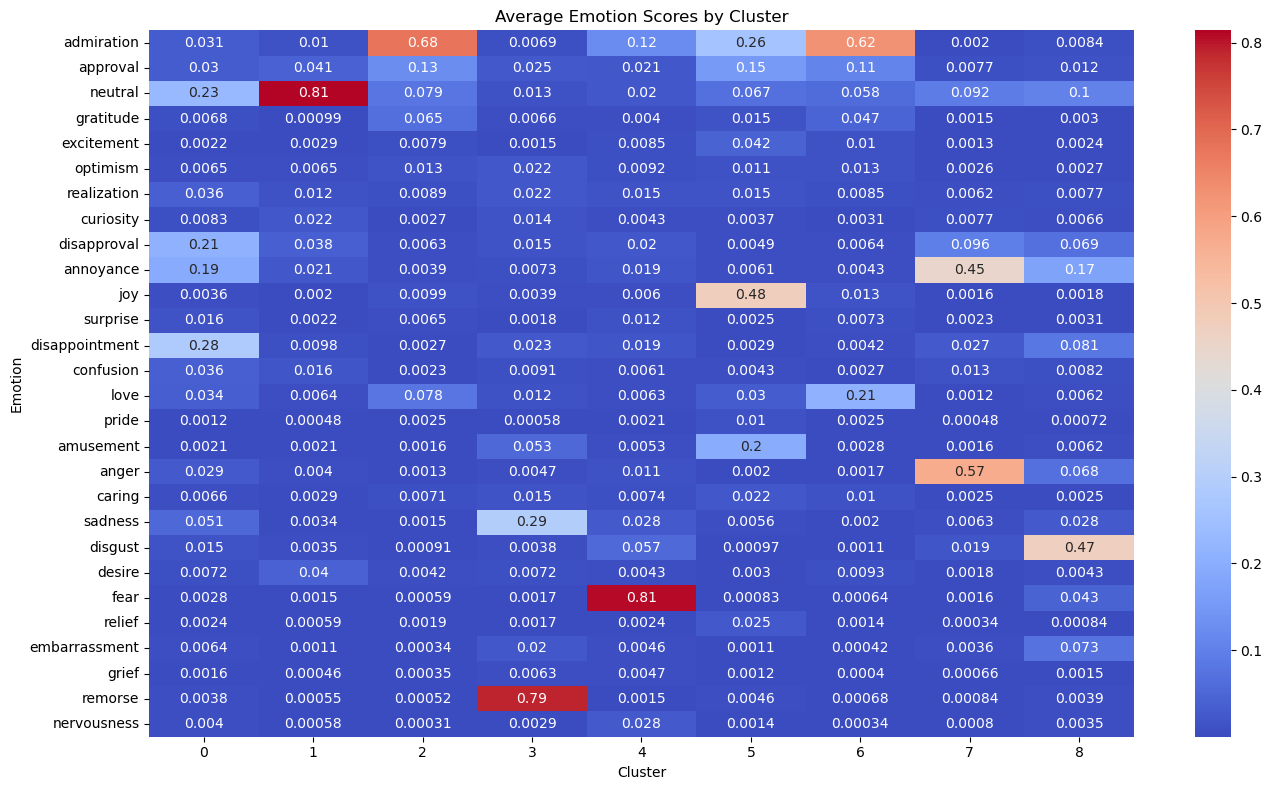

In [109]:
plt.figure(figsize=(14, 8))
sns.heatmap(sentiment_profiles.T, annot=True, cmap="coolwarm")
plt.title("Average Emotion Scores by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Emotion")
plt.tight_layout()
plt.show()

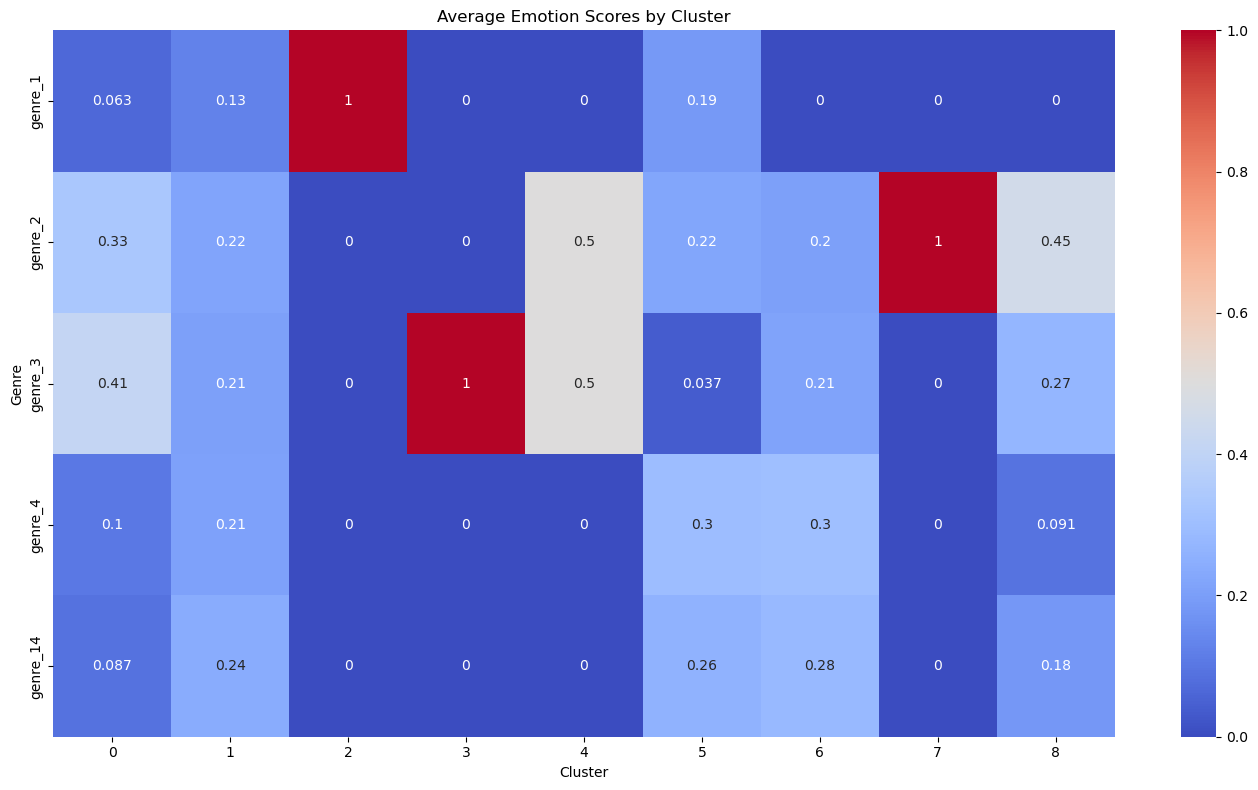

In [117]:
plt.figure(figsize=(14, 8))
sns.heatmap(genre_profiles.T, annot=True, cmap="coolwarm")
plt.title("Average Emotion Scores by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

In [111]:
top_emotions_per_cluster = sentiment_profiles.apply(lambda row: row.sort_values(ascending=False).head(3).index.tolist(), axis=1)
print(top_emotions_per_cluster)

cluster
0    [disappointment, neutral, disapproval]
1               [neutral, approval, desire]
2           [admiration, approval, neutral]
3             [remorse, sadness, amusement]
4               [fear, admiration, disgust]
5              [joy, admiration, amusement]
6              [admiration, love, approval]
7           [anger, annoyance, disapproval]
8             [disgust, annoyance, neutral]
dtype: object


In [113]:
df['usersk']

0         11
1         26
2         55
3         80
4         81
       ...  
995    22902
996    22923
997    22931
998    22932
999    22945
Name: usersk, Length: 1000, dtype: int64

In [119]:
user_review=reviews_dumm.reset_index()
user_review['usersk']=df['usersk'].values
user_review=user_review.drop('reviewsk', axis=1)
user_review

,admiration,approval,neutral,gratitude,excitement,optimism,realization,curiosity,disapproval,annoyance,...,remorse,nervousness,score,genre_1,genre_2,genre_3,genre_4,genre_14,cluster,usersk
0,0.952407,0.035722,0.018621,0.008089,0.005357,0.005288,0.004592,0.004367,0.004235,0.003373,...,0.000288,0.000176,4.0,False,False,False,False,True,6,11
1,0.030679,0.868227,0.059097,0.007364,0.002846,0.024590,0.033193,0.004353,0.005637,0.005220,...,0.000667,0.000595,5.0,False,True,False,False,False,6,26
2,0.002395,0.016938,0.944641,0.000312,0.002955,0.001597,0.005774,0.004531,0.003291,0.005071,...,0.000344,0.000523,1.0,False,False,False,False,True,1,55
3,0.895078,0.183130,0.032946,0.027178,0.004543,0.019904,0.005812,0.003366,0.004887,0.003214,...,0.000416,0.000172,5.0,True,False,False,False,False,2,80
4,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.000267,0.000153,4.0,True,False,False,False,False,2,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.005964,0.015944,0.964291,0.001109,0.003557,0.001710,0.006545,0.001215,0.003085,0.005875,...,0.000397,0.000439,5.0,False,False,False,True,False,1,22902
996,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.000267,0.000153,5.0,False,False,False,True,False,6,22923
997,0.002448,0.010344,0.963239,0.000718,0.001568,0.001811,0.005072,0.001494,0.003932,0.011296,...,0.000471,0.000556,5.0,False,False,True,False,False,1,22931
998,0.001767,0.043971,0.156199,0.000829,0.001430,0.008928,0.018048,0.002021,0.784211,0.081182,...,0.001832,0.001210,1.0,False,False,True,False,False,0,22932


In [129]:
sentiments=reviews_analized.drop(['score', 'genre','cluster'], axis=1).columns.values
sentiments

array(['admiration', 'approval', 'neutral', 'gratitude', 'excitement',
       'optimism', 'realization', 'curiosity', 'disapproval', 'annoyance',
       'joy', 'surprise', 'disappointment', 'confusion', 'love', 'pride',
       'amusement', 'anger', 'caring', 'sadness', 'disgust', 'desire',
       'fear', 'relief', 'embarrassment', 'grief', 'remorse',
       'nervousness'], dtype=object)

In [135]:
user_emotions = user_review.groupby('usersk').mean()[sentiments]
user_emotions

,admiration,approval,neutral,gratitude,excitement,optimism,realization,curiosity,disapproval,annoyance,...,caring,sadness,disgust,desire,fear,relief,embarrassment,grief,remorse,nervousness
usersk,,,,,,,,,,,,,,,,,,,,,
11,0.952407,0.035722,0.018621,0.008089,0.005357,0.005288,0.004592,0.004367,0.004235,0.003373,...,0.001536,0.001472,0.000938,0.000908,0.000521,0.000505,0.000333,0.000319,0.000288,0.000176
26,0.030679,0.868227,0.059097,0.007364,0.002846,0.024590,0.033193,0.004353,0.005637,0.005220,...,0.003570,0.001319,0.001651,0.001940,0.001526,0.002888,0.000577,0.000359,0.000667,0.000595
55,0.002395,0.016938,0.944641,0.000312,0.002955,0.001597,0.005774,0.004531,0.003291,0.005071,...,0.001200,0.003185,0.002785,0.000927,0.002556,0.000289,0.000834,0.000595,0.000344,0.000523
80,0.895078,0.183130,0.032946,0.027178,0.004543,0.019904,0.005812,0.003366,0.004887,0.003214,...,0.006739,0.000964,0.000635,0.005343,0.000363,0.000969,0.000182,0.000255,0.000416,0.000172
81,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.002440,0.001117,0.000537,0.000856,0.000362,0.001348,0.000221,0.000307,0.000267,0.000153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22902,0.005964,0.015944,0.964291,0.001109,0.003557,0.001710,0.006545,0.001215,0.003085,0.005875,...,0.000905,0.002243,0.003019,0.001146,0.002169,0.000477,0.000943,0.000512,0.000397,0.000439
22923,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.002440,0.001117,0.000537,0.000856,0.000362,0.001348,0.000221,0.000307,0.000267,0.000153
22931,0.002448,0.010344,0.963239,0.000718,0.001568,0.001811,0.005072,0.001494,0.003932,0.011296,...,0.001592,0.003400,0.005181,0.001540,0.002946,0.000352,0.001108,0.000594,0.000471,0.000556


In [143]:
user_genre = user_review.groupby('usersk').sum().filter(like='genre')
user_genre_pct = user_genre.div(user_genre.sum(axis=1), axis=0)
user_genre_pct

,genre_1,genre_2,genre_3,genre_4,genre_14
usersk,,,,,
11,0.0,0.0,0.0,0.0,1.0
26,0.0,1.0,0.0,0.0,0.0
55,0.0,0.0,0.0,0.0,1.0
80,1.0,0.0,0.0,0.0,0.0
81,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
22902,0.0,0.0,0.0,1.0,0.0
22923,0.0,0.0,0.0,1.0,0.0
22931,0.0,0.0,1.0,0.0,0.0


In [145]:
user_final = pd.concat([user_emotions, user_genre_pct], axis=1)
user_final

,admiration,approval,neutral,gratitude,excitement,optimism,realization,curiosity,disapproval,annoyance,...,relief,embarrassment,grief,remorse,nervousness,genre_1,genre_2,genre_3,genre_4,genre_14
usersk,,,,,,,,,,,,,,,,,,,,,
11,0.952407,0.035722,0.018621,0.008089,0.005357,0.005288,0.004592,0.004367,0.004235,0.003373,...,0.000505,0.000333,0.000319,0.000288,0.000176,0.0,0.0,0.0,0.0,1.0
26,0.030679,0.868227,0.059097,0.007364,0.002846,0.024590,0.033193,0.004353,0.005637,0.005220,...,0.002888,0.000577,0.000359,0.000667,0.000595,0.0,1.0,0.0,0.0,0.0
55,0.002395,0.016938,0.944641,0.000312,0.002955,0.001597,0.005774,0.004531,0.003291,0.005071,...,0.000289,0.000834,0.000595,0.000344,0.000523,0.0,0.0,0.0,0.0,1.0
80,0.895078,0.183130,0.032946,0.027178,0.004543,0.019904,0.005812,0.003366,0.004887,0.003214,...,0.000969,0.000182,0.000255,0.000416,0.000172,1.0,0.0,0.0,0.0,0.0
81,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.001348,0.000221,0.000307,0.000267,0.000153,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22902,0.005964,0.015944,0.964291,0.001109,0.003557,0.001710,0.006545,0.001215,0.003085,0.005875,...,0.000477,0.000943,0.000512,0.000397,0.000439,0.0,0.0,0.0,1.0,0.0
22923,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.001348,0.000221,0.000307,0.000267,0.000153,0.0,0.0,0.0,1.0,0.0
22931,0.002448,0.010344,0.963239,0.000718,0.001568,0.001811,0.005072,0.001494,0.003932,0.011296,...,0.000352,0.001108,0.000594,0.000471,0.000556,0.0,0.0,1.0,0.0,0.0


In [155]:
X_user = scaler.fit_transform(user_final)

In [157]:
best_k = 0
best_score = -1

for k in range(2, 10):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_user)
    score = silhouette_score(X_user, labels)
    print(f"k={k}, silhouette_score={score:.4f}")
    
    if score > best_score:
        best_k = k
        best_score = score

print(f"Best k based on silhouette score: {best_k}")

C:\Users\ale11\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\ale11\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\ale11\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\ale11\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

k=2, silhouette_score=0.3377
k=3, silhouette_score=0.0755
k=4, silhouette_score=0.1168
k=5, silhouette_score=0.1281
k=6, silhouette_score=0.1340
k=7, silhouette_score=0.1384
k=8, silhouette_score=0.1727
k=9, silhouette_score=0.1810
Best k based on silhouette score: 2


C:\Users\ale11\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\ale11\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [161]:
k = 9  # Or run elbow/silhouette stuff again
user_model = KMeans(n_clusters=k, random_state=42)
user_clusters = user_model.fit_predict(X_user)

user_final['user_cluster'] = user_clusters
user_final

C:\Users\ale11\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


,admiration,approval,neutral,gratitude,excitement,optimism,realization,curiosity,disapproval,annoyance,...,embarrassment,grief,remorse,nervousness,genre_1,genre_2,genre_3,genre_4,genre_14,user_cluster
usersk,,,,,,,,,,,,,,,,,,,,,
11,0.952407,0.035722,0.018621,0.008089,0.005357,0.005288,0.004592,0.004367,0.004235,0.003373,...,0.000333,0.000319,0.000288,0.000176,0.0,0.0,0.0,0.0,1.0,4
26,0.030679,0.868227,0.059097,0.007364,0.002846,0.024590,0.033193,0.004353,0.005637,0.005220,...,0.000577,0.000359,0.000667,0.000595,0.0,1.0,0.0,0.0,0.0,8
55,0.002395,0.016938,0.944641,0.000312,0.002955,0.001597,0.005774,0.004531,0.003291,0.005071,...,0.000834,0.000595,0.000344,0.000523,0.0,0.0,0.0,0.0,1.0,4
80,0.895078,0.183130,0.032946,0.027178,0.004543,0.019904,0.005812,0.003366,0.004887,0.003214,...,0.000182,0.000255,0.000416,0.000172,1.0,0.0,0.0,0.0,0.0,6
81,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.000221,0.000307,0.000267,0.000153,1.0,0.0,0.0,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22902,0.005964,0.015944,0.964291,0.001109,0.003557,0.001710,0.006545,0.001215,0.003085,0.005875,...,0.000943,0.000512,0.000397,0.000439,0.0,0.0,0.0,1.0,0.0,1
22923,0.906769,0.091215,0.025099,0.019495,0.005126,0.007412,0.005841,0.001876,0.003868,0.002191,...,0.000221,0.000307,0.000267,0.000153,0.0,0.0,0.0,1.0,0.0,1
22931,0.002448,0.010344,0.963239,0.000718,0.001568,0.001811,0.005072,0.001494,0.003932,0.011296,...,0.001108,0.000594,0.000471,0.000556,0.0,0.0,1.0,0.0,0.0,1


In [163]:
cluster_users = user_final.groupby('user_cluster').mean()
cluster_users

,admiration,approval,neutral,gratitude,excitement,optimism,realization,curiosity,disapproval,annoyance,...,relief,embarrassment,grief,remorse,nervousness,genre_1,genre_2,genre_3,genre_4,genre_14
user_cluster,,,,,,,,,,,,,,,,,,,,,
0,0.027411,0.024214,0.209034,0.001467,0.002252,0.007925,0.038482,0.008683,0.110942,0.130154,...,0.002951,0.007775,0.002701,0.021050,0.006779,0.018519,0.277778,0.537037,0.092593,0.074074
1,0.356759,0.083394,0.329507,0.030574,0.005610,0.012596,0.011824,0.014949,0.037678,0.017972,...,0.001212,0.000932,0.000455,0.000807,0.000534,0.000000,0.000000,0.461538,0.538462,0.000000
2,0.004276,0.016191,0.121656,0.017762,0.001814,0.003792,0.010235,0.006005,0.159592,0.391132,...,0.000997,0.025424,0.000928,0.002043,0.002156,0.076923,0.461538,0.282051,0.102564,0.076923
3,0.250682,0.158560,0.072708,0.018054,0.023009,0.011828,0.015605,0.002491,0.004864,0.006177,...,0.026328,0.001097,0.001224,0.004704,0.001366,0.222222,0.222222,0.037037,0.259259,0.259259
4,0.402718,0.050191,0.360141,0.026914,0.007808,0.005451,0.007133,0.003651,0.014789,0.011198,...,0.000769,0.000703,0.000447,0.000571,0.000455,0.000000,0.000000,0.000000,0.000000,1.000000
5,0.122244,0.021275,0.020417,0.004008,0.008516,0.009177,0.015054,0.004256,0.020127,0.018708,...,0.002379,0.004620,0.004689,0.001521,0.027967,0.000000,0.500000,0.500000,0.000000,0.000000
6,0.541916,0.102651,0.243030,0.051846,0.005740,0.010804,0.008547,0.003701,0.018153,0.010271,...,0.001401,0.000560,0.000377,0.000504,0.000370,1.000000,0.000000,0.000000,0.000000,0.000000
7,0.126323,0.020921,0.066789,0.003240,0.184433,0.009461,0.038399,0.020663,0.005710,0.007977,...,0.002102,0.003309,0.001256,0.000845,0.001082,0.142857,0.142857,0.285714,0.285714,0.142857
8,0.341512,0.106427,0.363017,0.022166,0.005360,0.011228,0.018881,0.012129,0.065888,0.024662,...,0.001621,0.001129,0.000460,0.000748,0.000672,0.000000,1.000000,0.000000,0.000000,0.000000


In [169]:
sentiment_users=cluster_users[reviews_analized.drop(['score', 'genre','cluster'], axis=1).columns]
sentiment_users

,admiration,approval,neutral,gratitude,excitement,optimism,realization,curiosity,disapproval,annoyance,...,caring,sadness,disgust,desire,fear,relief,embarrassment,grief,remorse,nervousness
user_cluster,,,,,,,,,,,,,,,,,,,,,
0,0.027411,0.024214,0.209034,0.001467,0.002252,0.007925,0.038482,0.008683,0.110942,0.130154,...,0.011044,0.108847,0.008520,0.011167,0.002385,0.002951,0.007775,0.002701,0.021050,0.006779
1,0.356759,0.083394,0.329507,0.030574,0.005610,0.012596,0.011824,0.014949,0.037678,0.017972,...,0.009266,0.003096,0.002488,0.018352,0.001041,0.001212,0.000932,0.000455,0.000807,0.000534
2,0.004276,0.016191,0.121656,0.017762,0.001814,0.003792,0.010235,0.006005,0.159592,0.391132,...,0.003348,0.014557,0.158799,0.004080,0.015337,0.000997,0.025424,0.000928,0.002043,0.002156
3,0.250682,0.158560,0.072708,0.018054,0.023009,0.011828,0.015605,0.002491,0.004864,0.006177,...,0.033883,0.005743,0.000963,0.002821,0.000832,0.026328,0.001097,0.001224,0.004704,0.001366
4,0.402718,0.050191,0.360141,0.026914,0.007808,0.005451,0.007133,0.003651,0.014789,0.011198,...,0.002260,0.003097,0.002109,0.035834,0.001046,0.000769,0.000703,0.000447,0.000571,0.000455
5,0.122244,0.021275,0.020417,0.004008,0.008516,0.009177,0.015054,0.004256,0.020127,0.018708,...,0.007445,0.028038,0.057290,0.004339,0.810459,0.002379,0.004620,0.004689,0.001521,0.027967
6,0.541916,0.102651,0.243030,0.051846,0.005740,0.010804,0.008547,0.003701,0.018153,0.010271,...,0.004174,0.002190,0.002308,0.003618,0.000811,0.001401,0.000560,0.000377,0.000504,0.000370
7,0.126323,0.020921,0.066789,0.003240,0.184433,0.009461,0.038399,0.020663,0.005710,0.007977,...,0.001420,0.002310,0.002326,0.003991,0.002111,0.002102,0.003309,0.001256,0.000845,0.001082
8,0.341512,0.106427,0.363017,0.022166,0.005360,0.011228,0.018881,0.012129,0.065888,0.024662,...,0.009064,0.003469,0.002820,0.015774,0.000925,0.001621,0.001129,0.000460,0.000748,0.000672


In [173]:
genre_users=cluster_users.filter(like='genre', axis=1)
genre_users

,genre_1,genre_2,genre_3,genre_4,genre_14
user_cluster,,,,,
0,0.018519,0.277778,0.537037,0.092593,0.074074
1,0.000000,0.000000,0.461538,0.538462,0.000000
2,0.076923,0.461538,0.282051,0.102564,0.076923
3,0.222222,0.222222,0.037037,0.259259,0.259259
4,0.000000,0.000000,0.000000,0.000000,1.000000
5,0.000000,0.500000,0.500000,0.000000,0.000000
6,1.000000,0.000000,0.000000,0.000000,0.000000
7,0.142857,0.142857,0.285714,0.285714,0.142857
8,0.000000,1.000000,0.000000,0.000000,0.000000


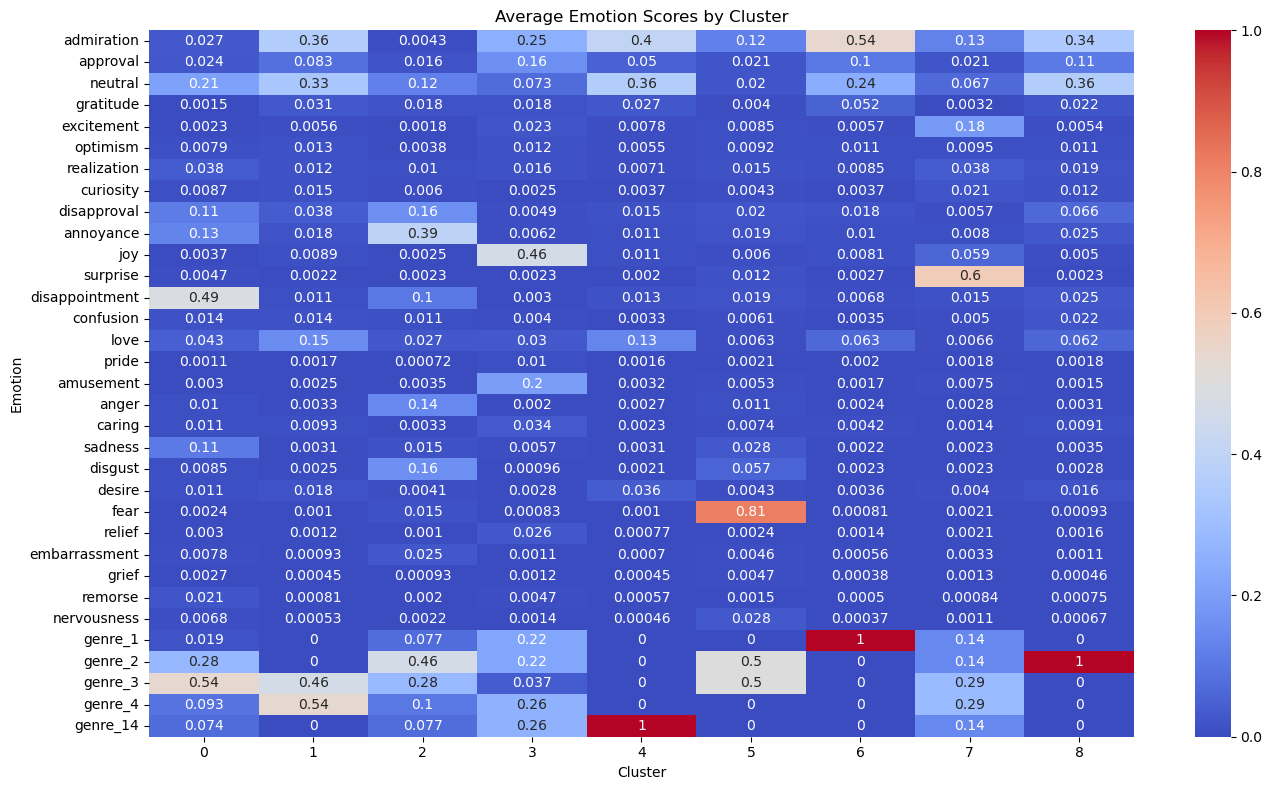

In [167]:
plt.figure(figsize=(14, 8))
sns.heatmap(sentiment_users.T, annot=True, cmap="coolwarm")
plt.title("Average Emotion Scores by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Emotion")
plt.tight_layout()
plt.show()

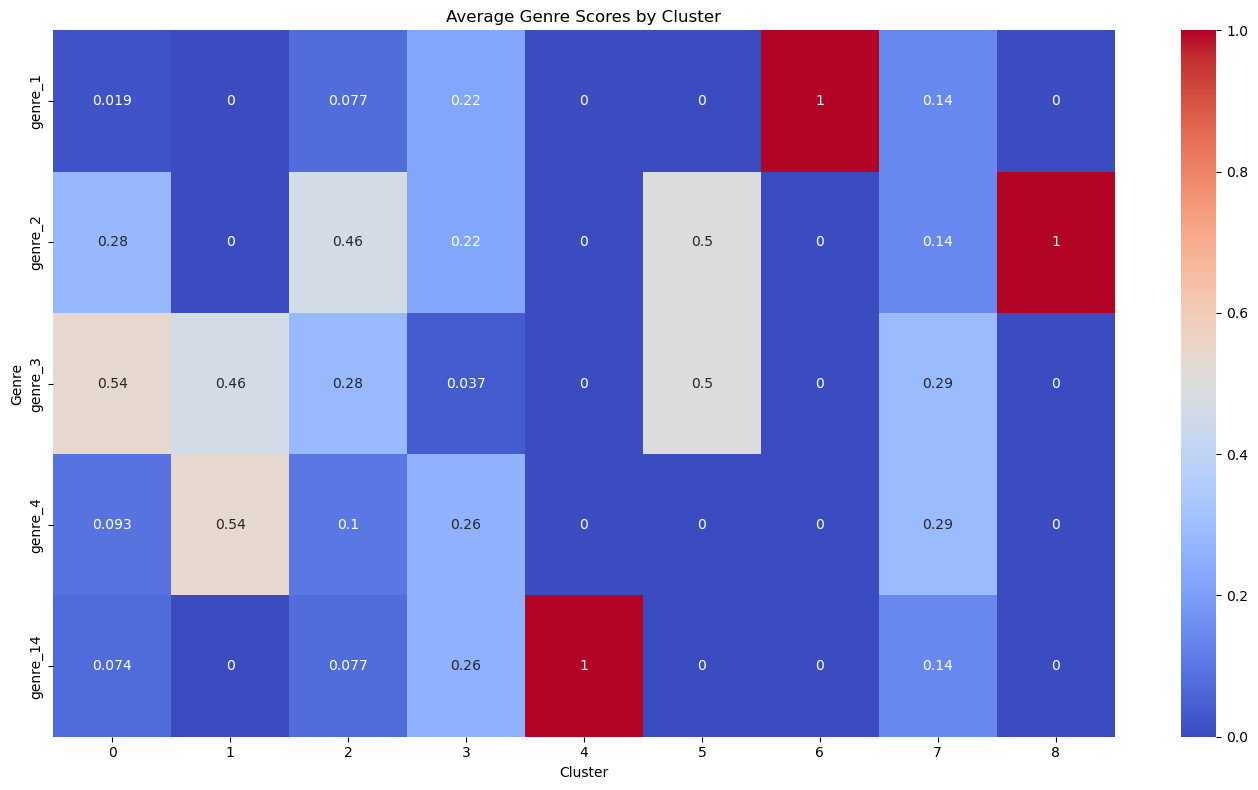

In [177]:
plt.figure(figsize=(14, 8))
sns.heatmap(genre_users.T, annot=True, cmap="coolwarm")
plt.title("Average Genre Scores by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

In [188]:
top_userEmotions_per_cluster = cluster_users.apply(lambda row: row.sort_values(ascending=False).head(3).index.tolist(), axis=1)
top_userEmotions_per_cluster

user_cluster
0       [approval, neutral, admiration]
1          [neutral, desire, gratitude]
2           [admiration, approval, joy]
3    [disappointment, sadness, neutral]
4     [annoyance, disapproval, neutral]
5    [surprise, excitement, admiration]
6            [joy, admiration, remorse]
7          [love, admiration, approval]
8       [sadness, disappointment, love]
dtype: object